In [55]:
import os
import scipy
import copy

import matplotlib.pyplot as plt
import numpy as np

from complex_network.networks import network_factory
from complex_network.networks.network_spec import NetworkSpec
from complex_network.perturbations.network_perturbator import (
    NetworkPerturbator,
)
from complex_network.perturbations import pole_finder

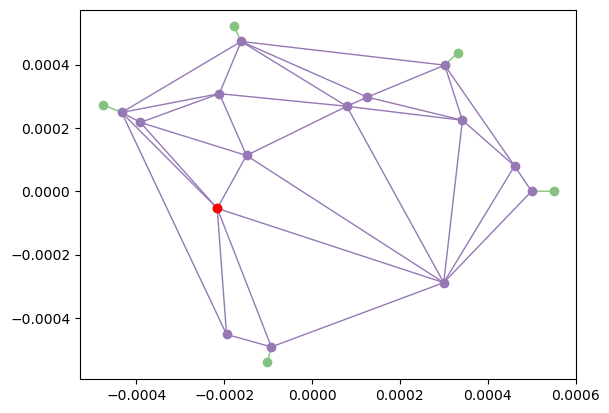

In [56]:
# Generate the random network
np.random.seed(1)
spec = NetworkSpec(
    network_type="delaunay",
    network_shape="circular",
    num_seed_nodes=0,
    external_offset=0.0,
    num_internal_nodes=15,
    num_external_nodes=5,
    network_size=500e-6,
    external_size=550e-6,
    node_S_mat_type="COE",
    node_S_mat_params={},
)
network = network_factory.generate_network(spec)
node_index = 9
network.draw(highlight_nodes=[node_index])

In [57]:
# Check that refractive index derivative is working properly
fn = network.n
fdn = network.dn

dk0 = 0.1

lam0 = 500e-9
k0 = 2 * np.pi / lam0
k1 = k0 + dk0

n0 = fn(k0)
n1 = fn(k1)

dndk = (n1 - n0) / dk0
theory = fdn(k0)

print(f"Calculated: {dndk}")
print(f"Theory: {theory}")
print(f"Difference: {np.abs(theory - dndk)}")

Calculated: 2.645519359134596e-09
Theory: 2.6455192676105925e-09
Difference: 9.152400354495752e-17


In [58]:
# Calculate the product S^dag S in three different ways
# REAL WAVENUMBER
lam0 = 500e-9
k0 = 2 * np.pi / lam0

# 1) Network matrix
S_network = network.get_S_matrix_direct(k0)
prod_network = np.conj(S_network.T) @ S_network

# 2) Formula
S_formula = network.get_S_ee(k0)
prod_formula = np.conj(S_formula.T) @ S_formula

# 3) Volume
U_0 = network.get_U_0(k0)
prod_volume = np.identity(len(U_0), dtype=np.complex128) - U_0

# Compare
print(f"Network vs Formula: {np.max(np.abs(prod_formula - prod_network))}")
print(f"Network vs Volume: {np.max(np.abs(prod_volume - prod_network))}")
print(prod_volume)

Network vs Formula: 1.2423395645555502e-13
Network vs Volume: 1.1968204205459188e-13
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [59]:
# Calculate the product S^dag S in three different ways
# COMPLEX WAVENUMBER
lam0 = 500e-9
k0 = 2 * np.pi / lam0 + 1j * np.random.randn()

# 1) Network matrix
S_network = network.get_S_matrix_direct(k0)
prod_network = np.conj(S_network.T) @ S_network

# 2) Formula
S_formula = network.get_S_ee(k0)
prod_formula = np.conj(S_formula.T) @ S_formula

# 3) Volume
U_0 = network.get_U_0(k0)
prod_volume = np.identity(len(U_0), dtype=np.complex128) - U_0

# Compare
print(f"Network vs Formula: {np.max(np.abs(prod_formula - prod_network))}")
print(f"Network vs Volume: {np.max(np.abs(prod_volume - prod_network))}")
print(prod_volume)

Network vs Formula: 9.248157795127554e-14
Network vs Volume: 9.525713551283843e-14
[[ 9.92000821e-01+0.j         -1.42478618e-03+0.00119134j
   2.92121362e-04-0.00015612j -3.99863964e-03-0.0019708j
   7.31040164e-04+0.00100905j]
 [-1.42478618e-03-0.00119134j  9.94386348e-01+0.j
   4.71717461e-04+0.00043651j -1.74859991e-03-0.00195226j
  -1.18910857e-03+0.00010546j]
 [ 2.92121362e-04+0.00015612j  4.71717461e-04-0.00043651j
   9.99347786e-01+0.j          3.02925501e-04+0.00011223j
   3.41391113e-04-0.00022819j]
 [-3.99863964e-03+0.0019708j  -1.74859991e-03+0.00195226j
   3.02925501e-04-0.00011223j  9.96119519e-01+0.j
   3.61705118e-04+0.00053475j]
 [ 7.31040164e-04-0.00100905j -1.18910857e-03-0.00010546j
   3.41391113e-04+0.00022819j  3.61705118e-04-0.00053475j
   9.98118138e-01+0.j        ]]


In [60]:
# Calculate Wigner Smith operator directly and using volume integrals
# REAL WAVENUMBER
lam0 = 500 - 9
k0 = 2 * np.pi / lam0

# 1) Direct
ws_direct = network.get_wigner_smith_k0(k0)

# 2) Volume integral method
n = network.n(k0)
dn = network.dn(k0)
U_0 = network.get_U_0(k0)
U_1 = network.get_U_1(k0)
U_2 = network.get_U_2(k0)
U_3 = network.get_U_3(k0)

pre_factor = np.linalg.inv(np.identity(len(U_0), dtype=np.complex128) - U_0)

first_term = (dn * k0 + n) * U_1
second_term = 0.5 * dn / n * np.imag(k0) / np.real(k0) * U_2
third_term = 1j * U_3
post_factor = first_term + second_term + third_term

ws_volume = pre_factor @ post_factor

# Compare
print(f"Difference: {np.max(np.abs(ws_volume - ws_direct))}")
print(ws_volume)

Difference: 1.7939683420790478e-15
[[ 0.02036244+0.j         -0.00278209-0.00367103j -0.00451159+0.00714118j
  -0.00016612-0.00557697j -0.00560407-0.00711793j]
 [-0.00278209+0.00367103j  0.02609687+0.j         -0.00271409+0.01030277j
   0.00398006+0.00215131j -0.00121431-0.00401132j]
 [-0.00451159-0.00714118j -0.00271409-0.01030277j  0.01527815+0.j
  -0.00116754-0.00232681j -0.00394688+0.0067487j ]
 [-0.00016612+0.00557697j  0.00398006-0.00215131j -0.00116754+0.00232681j
   0.00407911+0.j          0.00030825-0.00221209j]
 [-0.00560407+0.00711793j -0.00121431+0.00401132j -0.00394688-0.0067487j
   0.00030825+0.00221209j  0.00940458+0.j        ]]


In [61]:
# Calculate Wigner Smith operator directly and using volume integrals
# COMPLEX WAVENUMBER
lam0 = 500 - 9
k0 = 2 * np.pi / lam0 + 1j * np.random.randn()

# 1) Direct
ws_direct = network.get_wigner_smith_k0(k0)

# 2) Volume integral method
n = network.n(k0)
dn = network.dn(k0)
U_0 = network.get_U_0(k0)
U_1 = network.get_U_1(k0)
U_2 = network.get_U_2(k0)
U_3 = network.get_U_3(k0, 1e-5)

pre_factor = np.linalg.inv(np.identity(len(U_0), dtype=np.complex128) - U_0)

first_term = (dn * k0 + n) * U_1
second_term = 0.5 * dn / n * np.imag(k0) / np.real(k0) * U_2
third_term = 1j * U_3

post_factor = first_term + second_term + third_term

ws_volume = pre_factor @ post_factor

# Compare
print(f"Difference: {np.max(np.abs(ws_volume - ws_direct))}")
print(ws_volume)

Difference: 8.008142945597444e-10
[[ 0.02035025+2.95110045e-04j -0.0028987 -3.21324229e-03j
  -0.00490311+6.85821307e-03j -0.00018824-5.50848698e-03j
  -0.00533152-7.23876542e-03j]
 [-0.0027044 +4.14381635e-03j  0.02607029+6.43604599e-04j
  -0.00343708+1.00764879e-02j  0.00401781+2.30432818e-03j
  -0.00085044-4.32633081e-03j]
 [-0.00409652-7.38933490e-03j -0.00197507-1.04705909e-02j
   0.01524501+7.74082931e-04j -0.001056  -2.37764550e-03j
  -0.00435232+6.49074014e-03j]
 [-0.00015072+5.64694011e-03j  0.00393441-2.00066468e-03j
  -0.00127448+2.26668619e-03j  0.00407834+1.07434341e-05j
   0.00036804-2.24885946e-03j]
 [-0.0058655 +6.97421915e-03j -0.00155051+3.66997416e-03j
  -0.00352121-6.97090888e-03j  0.00025224+2.17005037e-03j
   0.00939191+2.92595293e-04j]]


In [62]:
# Calculate alpha Wigner Smith operator directly and using volume integrals
# COMPLEX WAVENUMBER
perturbator = NetworkPerturbator(network)

lam0 = 500 - 9
k0 = 2 * np.pi / lam0 + 1j  * np.random.randn()

# Apply the perturbation
eigenvalue_index = 0
alpha = 1e-3
perturbator.perturb_node_eigenvalue(node_index, eigenvalue_index, alpha)

# 1) Direct
ws_direct = perturbator.unperturbed_network.get_wigner_smith_t(
    k0, node_index, eigenvalue_index
)

# 2) Volume integral method
U_0 = perturbator.unperturbed_network.get_U_0(k0)
U_3 = perturbator.get_U_3_alpha(k0)

pre_factor = np.linalg.inv(np.identity(len(U_0), dtype=np.complex128) - U_0)

post_factor = 1j * U_3
ws_volume = pre_factor @ post_factor

# Compare
print(f"Difference: {np.max(np.abs(ws_volume - ws_direct))}")
print(ws_volume)
print("---")
print(ws_direct)

Difference: 2.0513168124320424
[[ 0.02023355+0.05228245j  0.0572958 -0.02308381j -0.02533471+0.02515692j
   0.02519549+0.00329809j  0.00520244-0.03196779j]
 [-0.08982811+0.21451492j  0.23770148+0.09572037j -0.14809165+0.00237834j
   0.06585694+0.08230814j  0.10747539-0.08063193j]
 [ 0.14406116+0.0038762j   0.00208959-0.15877788j  0.03453043+0.08503684j
   0.03281405-0.05648096j -0.07065283-0.04404805j]
 [-0.0112436 +0.04347657j  0.04807048+0.01172941j -0.02823623+0.00454386j
   0.01485878+0.01391143j  0.01831317-0.0183774j ]
 [-0.05478307-0.05799448j -0.06306596+0.06123518j  0.01984355-0.04677229j
  -0.03496807+0.00920935j  0.01034376+0.04491472j]]
---
[[ 1.7206527 +0.04112495j  0.01925969-1.89634948j  0.41544556+1.01435098j
   0.38986994-0.67572584j -0.84538269-0.52352847j]
 [-0.14013529+2.07553294j  2.28883728+0.12297152j -1.24667838+0.44831485j
   0.79544135+0.50630115j  0.67661542-0.99327457j]
 [ 0.5638259 -0.96462883j -1.07131455-0.60659054j  0.70677103+0.08258533j
  -0.2614377 -0

In [63]:
# # network.draw(show_indices=True)

# # Away from pole
# k0 = 12532230.332102112 - 1.136143180724291j
# step_matrix = network.get_network_step_matrix(k0)
# lam, v = np.linalg.eig(step_matrix)
# modified_lam = np.where(np.isclose(lam, 1.0 + 0.0 * 1j), lam, 0.0)
# network_matrix = v @ np.diag(modified_lam) @ np.linalg.inv(v)


# # Find a pole (guess has already been precalculated)
# # and show that it works
# guess = 12532230.332102112 - 11.136143180724291j
# pole = pole_finder.find_pole(network, guess)
# step_matrix = network.get_network_step_matrix(pole)
# lam, v = np.linalg.eig(step_matrix)
# modified_lam = np.where(np.isclose(lam, 1.0 + 0.0 * 1j), lam, 0.0)
# network_matrix = v @ np.diag(modified_lam) @ np.linalg.inv(v)

# num_externals = network.num_external_nodes
# incident_vector = np.zeros((len(network_matrix)), dtype=np.complex128)
# incident_field = np.array([1.0,0.0,0.0,0.0,0.0])
# incident_vector[num_externals : 2 * num_externals] = incident_field

# # Get from direct product with the network matrix (is this really correct?)
# outgoing_vector_one = network_matrix @ incident_vector

# # Do it manually from the eigendecomposition. Think through the steps...
# # N = Q L Q^-1
# v_inv = np.linalg.inv(v)

# one = v_inv @ incident_vector


# S_ee = network.get_S_ee(pole)
# S_ee2 = network.get_S_matrix_direct(pole)
# S_ee_inv = network.get_S_ee_inv(pole)
# print("")
# print("Pole of unperturbed network")
# print(f"det(S): {np.abs(np.linalg.det(S_ee))}")
# print(f"det(S^-1): {np.abs(np.linalg.det(S_ee_inv))}")


# product = np.conj(S_ee2).T @ S_ee2
# product_vol = np.identity(len(product), dtype=np.complex128) - network.get_U_0(
#     pole
# )
# diff = product - product_vol
# print(diff)

# # Test that the volume integrals work
# node_index = 9
# eigenvalue_index = 0
# perturbator.perturb_node_eigenvalue(node_index, eigenvalue_index, 0.01)


# # # Set up sequence of perturbations
# # angles = np.linspace(0, 2*np.pi, 1000)
# # poles, pole_shifts = perturbator.perturb_node_eigenvalue_iterative(
# #     pole, node_index, eigenvalue_index, angles
# # )
# # print(f"Direct: {pole_shifts["direct"]}")
# # print(f"Network: {pole_shifts["network"]}")
# # print(f"Wigner: {pole_shifts["wigner"]}")

# # # Plot pole shifts over complex plane
# # fig, ax = plt.subplots()
# # ax.plot(np.real(poles["direct"]), np.imag(poles["direct"]), color="tab:blue")
# # ax.plot(np.real(poles["network"]), np.imag(poles["network"]), color="tab:orange")
# # ax.plot(np.real(poles["wigner"]), np.imag(poles["wigner"]), color="tab:green")